## Heading and INtroduction

## Loading the dataset

We will use the [🤗 Datasets](https://github.com/huggingface/datasets) library to load the data . This can be easily done with the functions `load_dataset`.  

In [1]:
from datasets import load_dataset

In [2]:
dataset = load_dataset('csv',data_files={'train':'Train.csv',
                                      'validation': 'Dev.csv',
                                      'test': 'Test.csv'})


Using custom data configuration default-cbcc8f9d3e18d149
Reusing dataset csv (C:\Users\debal\.cache\huggingface\datasets\csv\default-cbcc8f9d3e18d149\0.0.0\2dc6629a9ff6b5697d82c25b73731dd440507a69cbce8b425db50b751e8fcfd0)


The `dataset` object itself is [`DatasetDict`](https://huggingface.co/docs/datasets/package_reference/main_classes.html#datasetdict), which contains one key for the training, validation and test set.

In [3]:
dataset

DatasetDict({
    train: Dataset({
        features: ['sent0', 'sent1', 'labels'],
        num_rows: 10000
    })
    validation: Dataset({
        features: ['labels', 'sent0', 'sent1'],
        num_rows: 997
    })
    test: Dataset({
        features: ['labels', 'sent0', 'sent1'],
        num_rows: 1000
    })
})

To access an actual element, you need to select a split first, then give an index:

In [4]:
dataset["train"][0]

{'sent0': 'He poured orange juice on his cereal.',
 'sent1': 'He poured milk on his cereal.',
 'labels': 1}

To get a sense of what the data looks like, the following function will show some examples picked randomly in the dataset.

In [5]:

## Should be changed using pandas
import datasets
import random
import pandas as pd
from IPython.display import display, HTML

def show_random_elements(dataset, num_examples=10):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)
    
    df = pd.DataFrame(dataset[picks])
    for column, typ in dataset.features.items():
        if isinstance(typ, datasets.ClassLabel):
            df[column] = df[column].transform(lambda i: typ.names[i])
    display(HTML(df.to_html()))

In [6]:
show_random_elements(dataset["train"])

,sent0,sent1,labels
0,We usually board the plane before going through the security check,We usually go through the security check before boarding the plane,1
1,he cooked the stove,he cooked the potatoes,1
2,You may find an elephant in the forest,You may find an anteater in the forest,0
3,my brother swimming on water every day,my brother swimming on petrol every day,0
4,Apples are made of molecules,Apples are made of stone,0
5,a bird flies in the sky,an elephant flies in the sky,0
6,Eating breakfast is bad for health.,Eating breakfast is good for health.,1
7,meeting my friends is for pleasure,meeting my friends is for business,0
8,He got out of his steering wheel.,He got out of his car.,1
9,There is 24 hours in a day.,There is multiple days in an hour.,0


## Sequence Model


We will now prepare data to be fed into the sequence model

In [7]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer  # White Space Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences # To get all sequences in same length
import numpy as np

In [13]:
def get_data(df):
    """
    df : Dataset object
    """
    sent_0 = df[:]['sent0']
    sent_1 = df[:]['sent1']
    data = [x+"<SEP>"+y for x,y in zip(sent_0,sent_1)]
    labels = np.array(df[:]['labels'],dtype=np.int32)
    
    return data, labels
    

In [14]:
train_data, train_labels = get_data(dataset['train'])
val_data, val_labels = get_data(dataset['validation'])
test_data, test_labels = get_data(dataset['test'])

In [8]:
tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n',oov_token="<UNK>")

In [15]:
tokenizer.fit_on_texts(train_data)

In [16]:
train_x = tokenizer.texts_to_sequences(train_data)
val_x = tokenizer.texts_to_sequences(val_data)
test_x = tokenizer.texts_to_sequences(test_data)

In [17]:
train_x = pad_sequences(train_x,maxlen=64,padding='post')
val_x = pad_sequences(val_x,maxlen=64,padding='post')
test_x = pad_sequences(test_x,maxlen=64,padding='post')

In [19]:
def create_model(num_words = len(tokenizer.index_word)+ 1 , embed_dim = 128):
    
    inp = tf.keras.layers.Input((64,))
    l_1 = tf.keras.layers.Embedding(num_words,embed_dim)(inp)
    #dp_1 = tf.keras.layers.Dropout(0.1)(l_1)
    l_2 = tf.keras.layers.LSTM(32)(l_1)
    bn_1 = tf.keras.layers.BatchNormalization()(l_2)
    dp_2 = tf.keras.layers.Dropout(0.1)(bn_1)
#     l_3 = tf.keras.layers.LSTM(64)(bn_1)
#     bn_2 = tf.keras.layers.BatchNormalization()(l_3)
#     dp_1 = tf.keras.layers.Dropout(0.1)(bn_2)
#     l_4 = tf.keras.layers.Dense(32,activation = 'relu')(dp_1)
#     bn_3 = tf.keras.layers.BatchNormalization()(l_4)
#     dp_2 = tf.keras.layers.Dropout(0.1)(bn_3)
    l_5 = tf.keras.layers.Dense(1,activation = 'sigmoid')(dp_2)
    
    return tf.keras.models.Model(inp,l_5)
    

In [20]:
Model = create_model()

In [21]:
Model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 64, 128)           1764608   
_________________________________________________________________
lstm (LSTM)                  (None, 32)                20608     
_________________________________________________________________
batch_normalization (BatchNo (None, 32)                128       
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 1,785,377
Trainable params: 1,785,313
Non-trainable params: 64
___________________________________________

In [22]:
Model.compile(optimizer=tf.keras.optimizers.Adam(0.001),loss=tf.keras.losses.BinaryCrossentropy(),metrics=['accuracy'])

In [23]:
Model.fit(x=train_x,y=train_labels,batch_size=128,epochs=5,validation_data=(val_x,val_labels))

Epoch 1/5
79/79 [==============================] - 5s 65ms/step - loss: 0.6933 - accuracy: 0.4914 - val_loss: 0.6928 - val_accuracy: 0.5196
Epoch 2/5
79/79 [==============================] - 3s 39ms/step - loss: 0.6911 - accuracy: 0.5200 - val_loss: 0.7061 - val_accuracy: 0.4804
Epoch 3/5
79/79 [==============================] - 3s 39ms/step - loss: 0.6349 - accuracy: 0.6442 - val_loss: 0.6932 - val_accuracy: 0.5216
Epoch 4/5
79/79 [==============================] - 3s 38ms/step - loss: 0.4748 - accuracy: 0.7739 - val_loss: 0.7041 - val_accuracy: 0.4945
Epoch 5/5
79/79 [==============================] - 3s 39ms/step - loss: 0.3378 - accuracy: 0.8551 - val_loss: 0.7832 - val_accuracy: 0.4995


In [24]:
import matplotlib.pyplot as plt

In [25]:
hist = Model.history.history

In [26]:
hist

{'loss': [0.6933149099349976,
  0.6911190152168274,
  0.6349160075187683,
  0.4748386740684509,
  0.3378404974937439],
 'accuracy': [0.49140000343322754,
  0.5199999809265137,
  0.6442000269889832,
  0.7738999724388123,
  0.8550999760627747],
 'val_loss': [0.6928151845932007,
  0.7060988545417786,
  0.6931532621383667,
  0.7041155099868774,
  0.7831624150276184],
 'val_accuracy': [0.5195586681365967,
  0.4804413318634033,
  0.5215647220611572,
  0.49448344111442566,
  0.49949848651885986]}

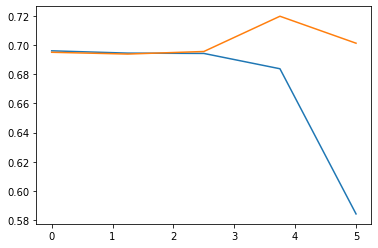

In [99]:
plt.plot(np.linspace(0,5,5),hist['loss'])
plt.plot(np.linspace(0,5,5),hist['val_loss'])

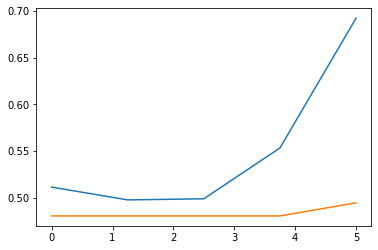

In [100]:
plt.plot(np.linspace(0,5,5),hist['accuracy'])
plt.plot(np.linspace(0,5,5),hist['val_accuracy'])

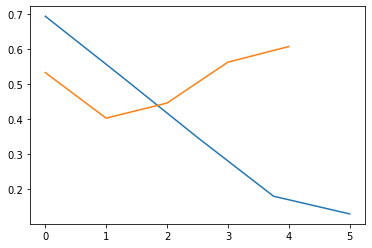

In [101]:
train = [0.694900,0.523100,0.348300,0.180200,0.129600]
val = [0.533820,0.403459,0.446641,0.563524,0.608211]
plt.plot(np.linspace(0,5,5),train,val)

In [ ]:
0.820461
0.830491 
0.837513    

In [ ]:
0.711133,
0.811434

## DistilBERT

In [3]:
import transformers

print(transformers.__version__)

4.7.0


In [4]:
task = "wnli"  # We are using this task as it is most similar to our task 
model_checkpoint = "distilbert-base-uncased"
batch_size = 16

## Loading the dataset

We will use the [🤗 Datasets](https://github.com/huggingface/datasets) library to download the data and get the metric we need to use for evaluation (to compare our model to the benchmark). This can be easily done with the functions `load_dataset` and `load_metric`.  

In [5]:
from datasets import load_metric

In [6]:
metric = load_metric('glue', task)

The metric is an instance of [`datasets.Metric`](https://huggingface.co/docs/datasets/package_reference/main_classes.html#datasets.Metric):

You can call its `compute` method with your predictions and labels directly and it will return a dictionary with the metric(s) value:

In [7]:
import numpy as np

fake_preds = np.random.randint(0, 2, size=(64,))
fake_labels = np.random.randint(0, 2, size=(64,))
metric.compute(predictions=fake_preds, references=fake_labels)

{'accuracy': 0.453125}

## Preprocessing the data

Before we can feed those texts to our model, we need to preprocess them. This is done by a 🤗 Transformers `Tokenizer` which will (as the name indicates) tokenize the inputs (including converting the tokens to their corresponding IDs in the pretrained vocabulary) and put it in a format the model expects, as well as generate the other inputs that model requires.

To do all of this, we instantiate our tokenizer with the `AutoTokenizer.from_pretrained` method, which will ensure:

- we get a tokenizer that corresponds to the model architecture we want to use,
- we download the vocabulary used when pretraining this specific checkpoint.

That vocabulary will be cached, so it's not downloaded again the next time we run the cell.

In [8]:
from transformers import AutoTokenizer
    
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True)

We pass along `use_fast=True` to the call above to use one of the fast tokenizers (backed by Rust) from the 🤗 Tokenizers library. Those fast tokenizers are available for almost all models, but if you got an error with the previous call, remove that argument.

You can directly call this tokenizer on one sentence or a pair of sentences:

In [9]:
x = tokenizer("Hello, this one sentence!", "And this sentence goes with it.")

In [10]:
tokenizer.decode(x['input_ids'])

'[CLS] hello, this one sentence! [SEP] and this sentence goes with it. [SEP]'

Depending on the model you selected, you will see different keys in the dictionary returned by the cell above. 

To preprocess our dataset, we will thus need the names of the columns containing the sentences.

We can them write the function that will preprocess our samples. We just feed them to the `tokenizer` with the argument `truncation=True`. This will ensure that an input longer that what the model selected can handle will be truncated to the maximum length accepted by the model.

In [11]:
def preprocess_function(examples):
    return tokenizer(examples['sent0'], examples['sent1'], truncation=True)

This function works with one or several examples. In the case of several examples, the tokenizer will return a list of lists for each key:

In [12]:
preprocess_function(dataset['train'][:5])

{'input_ids': [[101, 2002, 8542, 4589, 10869, 2006, 2010, 20943, 1012, 102, 2002, 8542, 6501, 2006, 2010, 20943, 1012, 102], [101, 2002, 8974, 6207, 1012, 102, 2002, 8974, 6501, 1012, 102], [101, 5076, 2743, 1037, 3542, 2651, 102, 5076, 2743, 2531, 1010, 2199, 2661, 2651, 102], [101, 1037, 22529, 12072, 2015, 2033, 102, 1045, 12072, 1037, 22529, 102], [101, 1037, 12286, 2003, 1037, 2711, 1012, 102, 1037, 21025, 27528, 7959, 2003, 1037, 2711, 1012, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}

To apply this function on all the sentences (or pairs of sentences) in our dataset, we just use the `map` method of our `dataset` object we created earlier. This will apply the function on all the elements of all the splits in `dataset`, so our training, validation and testing data will be preprocessed in one single command.

In [13]:
encoded_dataset = dataset.map(preprocess_function, batched=True)

Loading cached processed dataset at C:\Users\debal\.cache\huggingface\datasets\csv\default-cbcc8f9d3e18d149\0.0.0\2dc6629a9ff6b5697d82c25b73731dd440507a69cbce8b425db50b751e8fcfd0\cache-084593d6b8bd8fd7.arrow
Loading cached processed dataset at C:\Users\debal\.cache\huggingface\datasets\csv\default-cbcc8f9d3e18d149\0.0.0\2dc6629a9ff6b5697d82c25b73731dd440507a69cbce8b425db50b751e8fcfd0\cache-f82f0674a3a5d5cc.arrow
Loading cached processed dataset at C:\Users\debal\.cache\huggingface\datasets\csv\default-cbcc8f9d3e18d149\0.0.0\2dc6629a9ff6b5697d82c25b73731dd440507a69cbce8b425db50b751e8fcfd0\cache-298e0a8c315507bf.arrow


In [14]:
encoded_dataset

DatasetDict({
    train: Dataset({
        features: ['attention_mask', 'input_ids', 'labels', 'sent0', 'sent1'],
        num_rows: 10000
    })
    validation: Dataset({
        features: ['attention_mask', 'input_ids', 'labels', 'sent0', 'sent1'],
        num_rows: 997
    })
    test: Dataset({
        features: ['attention_mask', 'input_ids', 'labels', 'sent0', 'sent1'],
        num_rows: 1000
    })
})

## Fine-tuning the model

Now that our data is ready, we can download the pretrained model and fine-tune it. Since our task is about sentence classification, we use the `AutoModelForSequenceClassification` class. Like with the tokenizer, the `from_pretrained` method will download and cache the model for us. We will aslo have to specify  the number of labels for our problem which is `2`.

In [15]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

num_labels = 2
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.weight', 'classifier

The warning is telling us we are throwing away some weights (the `vocab_transform` and `vocab_layer_norm` layers) and randomly initializing some other (the `pre_classifier` and `classifier` layers). This is absolutely normal in this case, because we are removing the head used to pretrain the model on a masked language modeling objective and replacing it with a new head for which we don't have pretrained weights, so the library warns us we should fine-tune this model before using it for inference, which is exactly what we are going to do.

To instantiate a `Trainer`, we will need to define two more things. The most important is the [`TrainingArguments`](https://huggingface.co/transformers/main_classes/trainer.html#transformers.TrainingArguments), which is a class that contains all the attributes to customize the training. It requires one folder name, which will be used to save the checkpoints of the model, and all other arguments are optional:

In [16]:
metric_name = "accuracy"
model_name = model_checkpoint.split("/")[-1]

args = TrainingArguments(
    "test-glue",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
)

Here we set the evaluation to be done at the end of each epoch, tweak the learning rate, use the `batch_size` defined at the top of the notebook and customize the number of epochs for training, as well as the weight decay. Since the best model might not be the one at the end of training, we ask the `Trainer` to load the best model it saved (according to `metric_name`) at the end of training.


The last thing to define for our `Trainer` is how to compute the metrics from the predictions. We need to define a function for this, which will just use the `metric` we loaded earlier, the only preprocessing we have to do is to take the argmax of our predicted logits

In [17]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

Then we just need to pass all of this along with our datasets to the `Trainer`:

In [18]:
trainer = Trainer(
    model,
    args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

You might wonder why we pass along the `tokenizer` when we already preprocessed our data. This is because we will use it once last time to make all the samples we gather the same length by applying padding, which requires knowing the model's preferences regarding padding (to the left or right? with which token?). The `tokenizer` has a pad method that will do all of this right for us, and the `Trainer` will use it. You can customize this part by defining and passing your own `data_collator` which will receive the samples like the dictionaries seen above and will need to return a dictionary of tensors.

In [19]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.693200,0.482532,0.743230
2,0.464100,0.423938,0.793380
3,0.321700,0.486285,0.816449
4,0.160400,0.673427,0.817452
5,0.121500,0.706629,0.824473


TrainOutput(global_step=3125, training_loss=0.3233246371459961, metrics={'train_runtime': 539.4, 'train_samples_per_second': 92.696, 'train_steps_per_second': 5.793, 'total_flos': 648713700888000.0, 'train_loss': 0.3233246371459961, 'epoch': 5.0})

We can now finetune our model by just calling the `train` method:

In [19]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.694900,0.533820,0.711133
2,0.523100,0.403459,0.811434
3,0.348300,0.446641,0.820461
4,0.180200,0.563524,0.830491
5,0.129600,0.608211,0.837513


TrainOutput(global_step=3125, training_loss=0.34703362365722656, metrics={'train_runtime': 556.4746, 'train_samples_per_second': 89.851, 'train_steps_per_second': 5.616, 'total_flos': 648713700888000.0, 'train_loss': 0.34703362365722656, 'epoch': 5.0})

We can check with the `evaluate` method that our `Trainer` did reload the best model properly (if it was not the last one):

In [21]:
trainer.evaluate()

{'eval_loss': 0.6082107424736023,
 'eval_accuracy': 0.8375125376128385,
 'eval_runtime': 2.756,
 'eval_samples_per_second': 361.756,
 'eval_steps_per_second': 22.859,
 'epoch': 5.0}